###Partitioning CIFAR-10/100 by Dirichle distribution

This is a short tutorial that demonstrates how to split CIFAR-10/100 data (from Pytorch's data sources) by a **Dirichlet distribution** into multiple (*N*) subsets, which can be used as client/user data partitions for FL research. The main steps are:
- Download raw datasets and do transformation.
- Logically split the whole dataset by label.
- Use numpy.random.dirichlet to generate *N* multinomial distributions (or the parameters thereof, more precisely).
- Use some method to generate *N* integers as the sizes of client datasets.
- Determine the number of instances in each class to be sampled for each client based on the two steps above.
- Class-wise sampling to build each client's dataset.


In [ ]:
# check the directory tree and create a dir for the CIFAR dataset
!ls -lh
!mkdir datasets

total 4.0K
drwxr-xr-x 1 root root 4.0K Oct  8 13:45 sample_data


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random

In [ ]:
# define the image transforms to be applied
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# download the data via torchvision
# for CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='datasets', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='datasets', train=False,
                                       download=True, transform=transform)
# for CIFAR-100
'''
trainset = torchvision.datasets.CIFAR100(root='datasets', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='datasets', train=False,
                                       download=True, transform=transform)
'''

data_name = trainset.__class__.__name__  # "CIFAR10"/"CIFAR100"
!ls -lh datasets/

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar-10-python.tar.gz to datasets
Files already downloaded and verified
total 163M
drwxr-xr-x 2 2156 1103 4.0K Jun  4  2009 cifar-10-batches-py
-rw-r--r-- 1 root root 163M Oct 12 14:08 cifar-10-python.tar.gz


The codes above is the standard practice of getting the CIFAR dataset under the PyTorch framework, which wraps the data in an object whose class inherits the **torch.utils.data.Dataset** and also defines the **transform** functions (which are applied when the \_\_getitem\_\_() is called in iteration).

The dataset object itself is iterable like a list while the raw data (before any transforms apply) and labels are also stored in the object:

In [ ]:
print("Metadata:")
print(trainset)
print(trainset.filename)
print(trainset.classes)
print("\nInputs and labels:")
print(trainset.data.shape)
print(len(trainset.targets))
print("\nIterating it gets one sample as a tuple (tensor_x, label_y):")
print(trainset[0])

Metadata:
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
cifar-10-python.tar.gz
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Inputs and labels:
(50000, 32, 32, 3)
50000

Iterating it gets one sample as a tuple (tensor_x, label_y):
(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.

Now we first split the whole dataset by label so as to have separate pools of data for each class. Note that the splitting is logical as the code below is only grouping the indices. As a result, the *indices_by_y* is a number-of-classes-long list, where each element is a list of indices of samples in the corresponding class.

In [ ]:
n_classes = len(trainset.classes)  # 10 for CIFAR-10, 100 for CIFAR-100
n_clients = 10  # number of client datasets to split into

# get data indices by label
indices_by_y = [[] for _ in range(n_classes)]
for s_id, sample in enumerate(trainset):
  indices_by_y[sample[1]].append(s_id)

In this step we define a Dirichlet distribution parameterized by a vector $\alpha$, which is of the same length as the multinomial distribution parameter vectors we are going to generate. There are three key pieces of logic here:

1. Generating a data distribution (with *C* classes) for a client is equivalent to generating a C-dimensional multinomial distribution (parameter vector).
2. A Dirichlet distribution, in a *C*-dimensional space, is the distribution over the vectors each of which corresponds to (the parameters of) a multinomial distribution. With a Dirichlet distribution we are actually sampling on the surface of a (*C*-1)-simplex (see the .gif below for a 3-dimensional example).
3. The concentration parameter $\alpha$ controls how likely the generated multinomial distribution deviates from uniform distribution.

<p align="center">
  <img src="https://miro.medium.com/max/875/1*_NdnljMqi8L2_lAYwH3JDQ.gif" width="450" height="450" />
</p>

<p align=center>
The demo by
<a href="https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d">Lettier from Medium.com</a>
</p>

For more theoretically details, see the following blogs and paper:
- [Lettier, Your Guide to Latent Dirichlet Allocation](https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d)
- [S. Liu, Dirichlet distribution - motivating LDA](https://towardsdatascience.com/dirichlet-distribution-a82ab942a879)
- [Wikipedia](https://en.wikipedia.org/wiki/Dirichlet_distribution)
- [Blei et al., Latent Dirichlet Allocation](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)

In the following code block, we call *numpy.random.dirichlet* to generate *N* (number of clients specified) multinomial distributions (or the parameters thereof, more precisely) and also generate *N* integers as the sizes of these client datasets. Then we determine the number of instances in each class to be sampled for each client based on the two steps above.

In [ ]:
# seeds
random.seed(10)
np.random.seed(22)
# generate multinomial distributions from Dirichlet distribution
alpha = tuple(1 for _ in range(n_classes))  # concentration parameter
client_label_dists = np.random.dirichlet(alpha, n_clients)  # distribution matrix
# generate client data size distribution
client_data_sizes = [int(len(trainset)/n_clients) for _ in range(n_clients)]
# prob * size = counts
client_label_counts = np.matmul(client_label_dists, np.diag(client_data_sizes)).astype(int)
print("label counts by clients:\n", client_label_counts)

label distribution by clients:
 [[1.00807407e-01 7.30705189e-02 9.37000140e-02 1.27494807e-02
  2.87886062e-02 2.66752380e-01 1.50905777e-02 3.33543582e-01
  1.46262105e-02 6.08712232e-02]
 [8.67125714e-02 1.02281615e-03 2.20341147e-01 3.44273641e-01
  5.53434675e-02 5.00862841e-02 1.09073151e-02 5.31800746e-02
  3.73190919e-02 1.40813591e-01]
 [3.69765408e-03 3.21978724e-01 2.00537978e-02 8.82050595e-02
  2.47595290e-02 2.13282698e-01 2.24293624e-01 5.27476094e-02
  1.97905292e-02 3.11907749e-02]
 [1.99055335e-02 2.67663230e-01 4.32589399e-02 2.27232362e-01
  2.83018311e-03 1.00424514e-01 7.24147552e-02 3.48846278e-03
  1.96668171e-01 6.61138484e-02]
 [2.89260279e-01 9.34626506e-02 1.36886586e-01 7.11726189e-02
  5.23009448e-02 1.11328244e-02 6.92439087e-04 1.04922892e-02
  3.31379748e-01 3.21962037e-03]
 [2.44432165e-04 9.08618368e-04 7.30547763e-02 1.13583608e-02
  4.43010647e-02 3.32557270e-01 6.96547500e-02 3.35521410e-02
  3.88613251e-02 3.95507262e-01]
 [1.12431413e-02 8.7662036

Now, based on the distribution of data for each client (stored in the array *client_label_counts*) we construct each client's dataset by class-wise sampling from the label-associated sample pools, i.e., *indices_by_y*.

**Note**: the resulting *subset_indices* are ordered by class label and can be *shuffled*. We do not shuffle here for a clear display of partitioning results.

In [ ]:
# build client datasets by class-wise sampling
client_datasets = []
for u in range(n_clients):
  subset_indices = []
  for c in range(n_classes):
    subset_indices += random.choices(population=indices_by_y[c], k=client_label_counts[u][c])
  # np.random.shuffle(subset_indices)
  client_datasets.append(torch.utils.data.Subset(trainset, subset_indices))


The following block shows the partitioning results like this (for CIFAR-10):

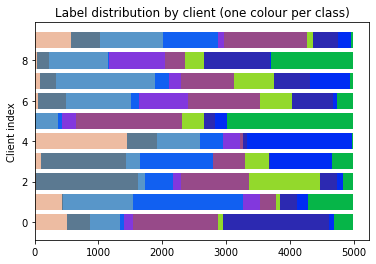


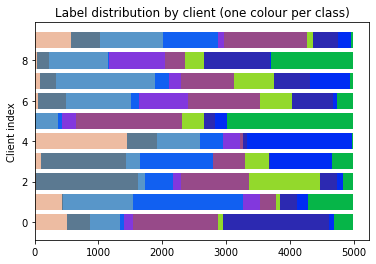

In [ ]:
# display label distribution by client
import matplotlib.pyplot as plt
shift = 0  # for stacking the bars
for c in range(n_classes):
  plt.barh(range(n_clients), client_label_counts[:, c], 
           left=shift, color=np.random.random(size=3))
  shift += client_label_counts[:, c]
plt.title("Label distribution by client (one colour per class)")
plt.ylabel('Client index')
plt.show()

Now one can wrap these partitioned client datasets into DataLoaders and train local models in an FL style.

In [ ]:
batch_size = 32
client_dataloaders = {}  # id:loader dict
for u_id in range(n_clients):
  client_dataloaders[u_id] = torch.utils.data.DataLoader(client_datasets[u_id], 
                                                         batch_size=batch_size,
                                                         shuffle=False, 
                                                         num_workers=1)